In [29]:
import numpy as np
from scipy.linalg import cholesky, eigvals
import random
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
# Cholesky that assumes PD matrix
def chol_pd(a):
    n = a.shape[0]
    root = np.zeros((n, n))

    for j in range(n):
        s = 0
        if j > 0:
            s = root[j, :j].dot(root[j, :j])
        root[j, j] = np.sqrt(a[j, j] - s)

        ir = 1 / root[j, j]
        for i in range(j + 1, n):
            s = root[i, :j].dot(root[j, :j])
            root[i, j] = (a[i, j] - s) * ir
    
    return root

In [31]:
n = 5
sigma = np.full((n, n), 0.9)
np.fill_diagonal(sigma, 1)

root = chol_pd(sigma)

assert np.allclose(root @ root.T, sigma)
root2 = cholesky(sigma, lower=True)
assert np.allclose(root, root2)

In [32]:
#make the matrix PSD
sigma[0, 1] = 1.0
sigma[1, 0] = 1.0
eigvals(sigma)


array([4.64053565e+00+0.j, 7.58008172e-17+0.j, 1.59464350e-01+0.j,
       1.00000000e-01+0.j, 1.00000000e-01+0.j])

In [33]:
#Cholesky that assumes PSD
def chol_psd(a):
    n = a.shape[0]
    root = np.zeros((n, n))

    for j in range(n):
        s = 0.0
        if j > 0:
            s = np.dot(root[j, :j], root[j, :j])
        temp = a[j, j] - s
        if temp <= 0:
            temp = 0.0
        root[j, j] = np.sqrt(temp)

        if root[j, j] == 0.0:
            root[j, j+1:] = 0.0
        else:
            ir = 1.0 / root[j, j]
            for i in range(j + 1, n):
                s = np.dot(root[i, :j], root[j, :j])
                root[i, j] = (a[i, j] - s) * ir
    return root

In [34]:
root = chol_psd(sigma)

np.allclose(root @ root.T, sigma)

#root2 = cholesky(sigma, lower=True)

True

In [35]:
#make the matrix slightly non-definite
sigma[0, 1] = 0.7357
sigma[1, 0] = 0.7357

eigvals = eigvals(sigma)

root = chol_psd(sigma)

In [46]:
#Generate some random numbers with missing values.
def generate_with_missing(n, m, pmiss=0.25):
    x = np.empty((n, m), dtype=object)

    for i in range(n):
        for j in range(m):
            if random.random() >= pmiss:
                x[i, j] = random.gauss(0, 1)
    return x

np.random.seed(2)
x = generate_with_missing(10, 5, pmiss=0.2)
print(x)
#np.cov(x) #should return error

[[-1.2259071267130286 0.48453092696177086 0.4284650214005919
  0.5909903193639889 -0.7687544406707938]
 [0.7007133170211296 -1.0732083543679476 1.2690196402883163
  -1.343086506474702 -0.6284131015787695]
 [None None -2.7411917120407177 0.2315219961746303 0.5129622012676365]
 [None -0.5820973090889364 -1.1734330850091814 0.4903522253314527
  -1.0808749746214548]
 [0.9111964577485349 None -1.313903116782275 -0.0702706363961844
  1.4339471840168998]
 [0.45681691610958947 1.0365750358033006 None -0.9335737286548141
  0.6140159169229719]
 [-0.09680603229471765 0.30258588015800497 -1.0733297951328051 None
  -0.5769203816975912]
 [1.4599798805406379 -0.8240226224633831 -1.5123911073877334 None None]
 [0.7440693675934162 0.41312874582999215 -0.2051241552956275
  0.7136351578362544 -0.43171849684761593]
 [-0.8749629864429733 1.570014390445903 0.12667500529070483 None
  0.7509079900232819]]


In [44]:
#calculate either the covariance or correlation function when there are missing values
def missing_cov(x, skipMiss=True, fun=np.cov):
    n, m = x.shape
    nMiss = np.count_nonzero(np.equal(x, None), axis=0)

    if np.sum(nMiss) == 0:
        return fun(x)

    idxMissing = []
    for j in range(m):
        idxMissing.append(np.where(np.equal((x[:, j]), None))[0])

    if skipMiss:
        rows = set(range(n))
        for c in range(m):
            for rm in idxMissing[c]:
                rows.remove(rm)
        rows = np.sort(list(rows))
        return fun(x[rows, :])
    else:
        out = np.empty((m, m), dtype=float)
        for i in range(m):
            for j in range(i, m):
                rows = set(range(n))
                for c in (i, j):
                    for rm in idxMissing[c]:
                        rows.remove(rm)
                rows = np.sort(list(rows))
                out[i, j] = fun(x[rows, [i, j]])[0, 1]
                if i != j:
                    out[j, i] = out[i, j]
        return out

In [45]:
skipMiss = missing_cov(x)


KeyError: 0

In [ ]:
pairwise = missing_cov(x, skipMiss=False)
eigvals(pairwise)

root = chol_psd(skipMiss)
root = chol_psd(pairwise)

In [91]:
#Look at Exponential Weights
def populateWeights(x, w, cw, λ):
    n = len(x)
    tw = 0.0
    for i in range(n):
        x[i] = i+1
        w[i] = (1-λ)*(λ**i)
        tw += w[i]
        cw[i] = tw
    for i in range(n):
        w[i] = w[i]/tw
        cw[i] = cw[i]/tw

In [92]:
weights = pd.DataFrame()
cumulative_weights = pd.DataFrame()
n=100
x = np.empty(n)
w = np.empty(n)
cumulative_w = np.empty(n)

In [94]:
#calculated weights λ=75%
populateWeights(x, w, cumulative_w, 0.75)
weights['x'] = x
weights['λ=0.75'] = w
cumulative_weights['x'] = x
cumulative_weights['λ=0.75'] = cumulative_w
weights

,x,λ=0.75
0,1.0,2.500000e-01
1,2.0,1.875000e-01
2,3.0,1.406250e-01
3,4.0,1.054688e-01
4,5.0,7.910156e-02
...,...,...
95,96.0,3.378781e-13
96,97.0,2.534086e-13
97,98.0,1.900564e-13
98,99.0,1.425423e-13


In [95]:
cumulative_w

array([0.25      , 0.4375    , 0.578125  , 0.68359375, 0.76269531,
       0.82202148, 0.86651611, 0.89988708, 0.92491531, 0.94368649,
       0.95776486, 0.96832365, 0.97624274, 0.98218205, 0.98663654,
       0.9899774 , 0.99248305, 0.99436229, 0.99577172, 0.99682879,
       0.99762159, 0.99821619, 0.99866214, 0.99899661, 0.99924746,
       0.99943559, 0.99957669, 0.99968252, 0.99976189, 0.99982142,
       0.99986606, 0.99989955, 0.99992466, 0.9999435 , 0.99995762,
       0.99996822, 0.99997616, 0.99998212, 0.99998659, 0.99998994,
       0.99999246, 0.99999434, 0.99999576, 0.99999682, 0.99999761,
       0.99999821, 0.99999866, 0.99999899, 0.99999924, 0.99999943,
       0.99999958, 0.99999968, 0.99999976, 0.99999982, 0.99999987,
       0.9999999 , 0.99999992, 0.99999994, 0.99999996, 0.99999997,
       0.99999998, 0.99999998, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [22]:
#calculated weights λ=90%
populateWeights(x, w, cumulative_w, 0.90)
weights['λ=0.90'] = w
cumulative_weights['λ=0.90'] = cumulative_w

#calculated weights λ=97%
populateWeights(x, w, cumulative_w, 0.97)
weights['λ=0.97'] = w
cumulative_weights['λ=0.97'] = cumulative_w

#calculated weights λ=99%
populateWeights(x, w, cumulative_w, 0.99)
weights['λ=0.99'] = w
cumulative_weights['λ=0.99'] = cumulative_w

In [23]:
print(weights)

        x        λ=0.75    λ=0.90    λ=0.97    λ=0.99
0     1.0  2.500000e-01  0.100003  0.031498  0.015774
1     2.0  1.875000e-01  0.090002  0.030553  0.015616
2     3.0  1.406250e-01  0.081002  0.029636  0.015460
3     4.0  1.054688e-01  0.072902  0.028747  0.015305
4     5.0  7.910156e-02  0.065612  0.027885  0.015152
..    ...           ...       ...       ...       ...
95   96.0  3.378781e-13  0.000004  0.001744  0.006071
96   97.0  2.534086e-13  0.000004  0.001692  0.006011
97   98.0  1.900564e-13  0.000004  0.001641  0.005950
98   99.0  1.425423e-13  0.000003  0.001592  0.005891
99  100.0  1.069067e-13  0.000003  0.001544  0.005832

[100 rows x 5 columns]


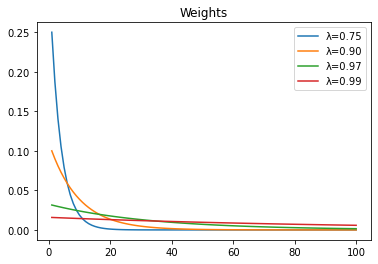

In [26]:
#plot Weights
for i in range(1, len(weights.columns)):
    plt.plot(weights['x'], weights.iloc[:, i])
plt.title("Weights")
plt.legend(weights.columns[1:])
plt.show()

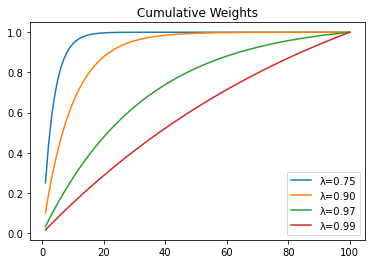

In [27]:
#plot the cumulative weights
for i in range(1, len(cumulative_weights.columns)):
    plt.plot(cumulative_weights['x'], cumulative_weights.iloc[:, i])
plt.title("Cumulative Weights")
plt.legend(cumulative_weights.columns[1:])
plt.show()

In [86]:
#Near PSD Matrix
def near_psd(a, epsilon=0.0):
    n = a.shape[0]

    invSD = None
    out = np.copy(a)

    #calculate the correlation matrix if we got a covariance
    if (np.diag(out) != 1.0).sum() != n:
        invSD = np.diag(1 / np.sqrt(np.diag(out)))
        out = invSD @ out @ invSD
    
    #SVD, update the eigen value and scale
    vals, vecs = np.linalg.eig(out)
    vals = np.maximum(vals,epsilon)
    T = 1 / (vecs * vals * vecs)
    T = np.diag(np.sqrt(T))
    l = np.diag(np.sqrt(vals))
    B = T @ vecs @ l
    out = B @ B.T

    #Add back the variance
    if invSD is not None:
        invSD = np.diag(1 / np.diag(invSD))
        out = invSD @ out @ invSD
    return out

#near_pairwise = near_psd(pairwise)

In [87]:
def simulate_pca(a, nsim, nval=None):
    # Eigenvalue decomposition
    vals, vecs = np.linalg.eig(a)

    # Sort the eigenvalues and corresponding eigenvectors in descending order
    idx = np.argsort(-vals)
    vals = vals[idx]
    vecs = vecs[:, idx]

    tv = np.sum(vals)

    posv = np.where(vals >= 1e-8)[0]
    if nval is not None:
        if nval < len(posv):
            posv = posv[:nval]
    vals = vals[posv]
    vecs = vecs[:, posv]

    print("Simulating with {} PC Factors: {:.2f}% total variance explained".format(len(posv), np.sum(vals)/tv*100))
    B = vecs @ np.diag(np.sqrt(vals))

    m = B.shape[1]
    r = np.random.randn(m, nsim)
    print(B)

    return np.dot(B, r).T

In [88]:
n = 5
sigma = np.full((n,n), 0.9)
np.fill_diagonal(sigma, 1.0)

sigma[0,1]=1
sigma[1,0]=1

v = np.diag(np.full(n, 0.5))
sigma = v @ sigma @ v
sigma

array([[0.25 , 0.25 , 0.225, 0.225, 0.225],
       [0.25 , 0.25 , 0.225, 0.225, 0.225],
       [0.225, 0.225, 0.25 , 0.225, 0.225],
       [0.225, 0.225, 0.225, 0.25 , 0.225],
       [0.225, 0.225, 0.225, 0.225, 0.25 ]])

In [89]:
sim = simulate_pca(sigma, 10000)
np.cov(sim.T)

Simulating with 4 PC Factors: 100.00% total variance explained
[[-4.88112864e-01  1.08378192e-01 -4.06381308e-19  1.67555306e-18]
 [-4.88112864e-01  1.08378192e-01 -2.89891900e-18  1.19525493e-17]
 [-4.77362747e-01 -7.38792316e-02 -3.13112146e-02  1.29099445e-01]
 [-4.77362747e-01 -7.38792316e-02 -9.28096216e-02 -6.45497224e-02]
 [-4.77362747e-01 -7.38792316e-02  1.24120836e-01 -6.45497224e-02]]


array([[0.25000387, 0.25000387, 0.22568664, 0.22622969, 0.22670428],
       [0.25000387, 0.25000387, 0.22568664, 0.22622969, 0.22670428],
       [0.22568664, 0.22568664, 0.25236855, 0.22943031, 0.22297936],
       [0.22622969, 0.22622969, 0.22943031, 0.24904303, 0.22910988],
       [0.22670428, 0.22670428, 0.22297936, 0.22910988, 0.25605789]])